*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2021-11-29 13:48:03--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.2’

book-crossings.zip. 100%[===================>]  24.88M   150MB/s    in 0.2s    

2021-11-29 13:48:03 (150 MB/s) - ‘book-crossings.zip.2’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [4]:
#Spy on data
print(df_books.head())
print()
print(df_ratings.head())
print()

         isbn  ...                author
0  0195153448  ...    Mark P. O. Morford
1  0002005018  ...  Richard Bruce Wright
2  0060973129  ...          Carlo D'Este
3  0374157065  ...      Gina Bari Kolata
4  0393045218  ...       E. J. W. Barber

[5 rows x 3 columns]

     user        isbn  rating
0  276725  034545104X     0.0
1  276726  0155061224     5.0
2  276727  0446520802     0.0
3  276729  052165615X     3.0
4  276729  0521795028     6.0



In [5]:
print('Books columns:',df_books.columns)
print('Rating columns:',df_ratings.columns)
print('Shape books:',df_books.shape)
print('Shape rating:',df_ratings.shape)

Books columns: Index(['isbn', 'title', 'author'], dtype='object')
Rating columns: Index(['user', 'isbn', 'rating'], dtype='object')
Shape books: (271379, 3)
Shape rating: (1149780, 3)


In [6]:
#Check types
print('Books types:',df_books.dtypes)
print('Rating types:',df_ratings.dtypes)

print('Unique Values rating', np.unique(df_ratings['rating']))

Books types: isbn      object
title     object
author    object
dtype: object
Rating types: user        int32
isbn       object
rating    float32
dtype: object
Unique Values rating [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


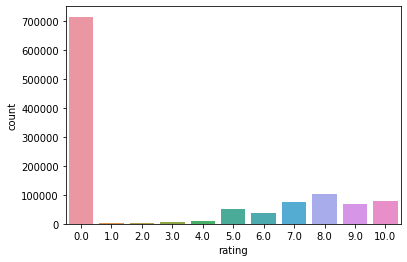

In [7]:
#The column rating have te most relevant values. Check it.
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(df_ratings.rating)
plt.show()

In [8]:
#Lets count the number of rating per book.
book_ratingCount = (df_ratings.
     groupby(by = ['isbn'])['user','rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'total_rating'})
     [['isbn', 'user', 'total_rating']]
    )
print('Total values: ', np.unique(book_ratingCount['total_rating']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Total values:  [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  184  185  186  187  188  189  190  191  192  193  194  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


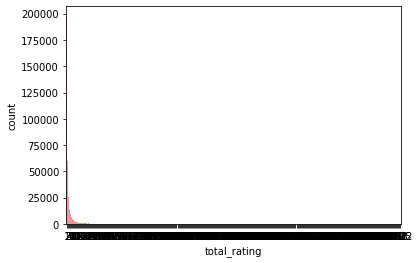

In [9]:
# Books with a low number of reviews
sns.countplot(book_ratingCount.total_rating)
plt.show()

In [10]:
#Remove books with total_rating less than x-value.
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['total_rating'].describe())

count   340556.000
mean         3.376
std         12.436
min          1.000
25%          1.000
50%          1.000
75%          2.000
max       2502.000
Name: total_rating, dtype: float64


In [11]:
#Remove books.
x_val = 50
book_ratingCount = book_ratingCount[book_ratingCount.total_rating >= x_val]
print(book_ratingCount.shape)
book_ratingCount.head()

(2185, 3)


,isbn,user,total_rating
1913,000649840X,89,89
2742,0007110928,50,50
3313,002026478X,69,69
3449,0020442203,66,66
3800,002542730X,171,171


In [12]:
#Get only books with rating > x_value from dataset df_books_ratings.
book_ratingCount_index = book_ratingCount['isbn']

df_books_ratting_positive = df_books[df_books['isbn'].isin(book_ratingCount_index)]
df_books_ratting_positive.head()

,isbn,title,author
18,0440234743,The Testament,John Grisham
19,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison
26,0971880107,Wild Animus,Rich Shapero
27,0345402871,Airframe,Michael Crichton
28,0345417623,Timeline,MICHAEL CRICHTON


In [13]:
#Spy on new data.
print('Previous size:',df_books.shape)
print('New size:',df_books_ratting_positive.shape)

print('Total rating values:',np.unique(book_ratingCount.total_rating))

Previous size: (271379, 3)
New size: (2161, 3)
Total rating values: [  50   51   52   53   54   55   56   57   58   59   60   61   62   63
   64   65   66   67   68   69   70   71   72   73   74   75   76   77
   78   79   80   81   82   83   84   85   86   87   88   89   90   91
   92   93   94   95   96   97   98   99  100  101  102  103  104  105
  106  107  108  109  110  111  112  113  114  115  116  117  118  119
  120  121  122  123  124  125  126  127  128  129  130  131  132  133
  134  135  136  137  138  139  140  141  142  143  144  145  146  147
  148  149  150  151  152  153  154  155  156  157  158  159  160  161
  162  163  164  165  166  167  168  169  170  171  172  173  174  175
  176  177  178  179  180  181  182  183  184  185  186  187  188  189
  190  191  192  193  194  195  196  197  198  199  200  201  202  203
  205  207  209  210  211  212  213  214  216  217  218  219  220  221
  222  224  225  226  227  228  229  230  232  233  235  236  237  239
  241  24

In [14]:
#Count user total reviews
total_user_count = (df_ratings.
     groupby(['user'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'total'})
     [['user', 'total']]
    )
print('Total values: ', np.unique(total_user_count['total']))
total_user_count.head()

Total values:  [    1     2     3     4     5     6     7     8     9    10    11    12
    13    14    15    16    17    18    19    20    21    22    23    24
    25    26    27    28    29    30    31    32    33    34    35    36
    37    38    39    40    41    42    43    44    45    46    47    48
    49    50    51    52    53    54    55    56    57    58    59    60
    61    62    63    64    65    66    67    68    69    70    71    72
    73    74    75    76    77    78    79    80    81    82    83    84
    85    86    87    88    89    90    91    92    93    94    95    96
    97    98    99   100   101   102   103   104   105   106   107   108
   109   110   111   112   113   114   115   116   117   118   119   120
   121   122   123   124   125   126   127   128   129   130   131   132
   133   134   135   136   137   138   139   140   141   142   143   144
   145   146   147   148   149   150   151   152   153   154   155   156
   157   158   159   160   161   162

,user,total
0,2,1
1,7,1
2,8,18
3,9,3
4,10,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


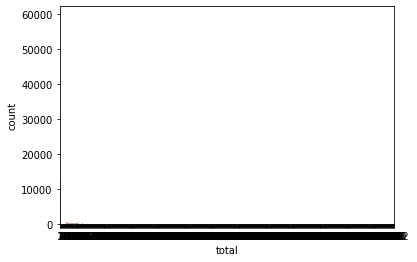

count   105283.000
mean        10.921
std         90.563
min          1.000
25%          1.000
50%          1.000
75%          4.000
max      13602.000
Name: total, dtype: float64


In [15]:
#Spy on count user reviews.
sns.countplot(total_user_count.total)
plt.show()

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(total_user_count['total'].describe())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


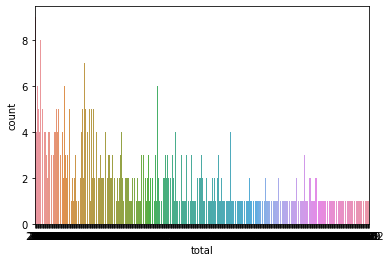

(905, 2)


In [16]:
#More than 75% of the users made only 1 or 2 reviews
x = 200
total_user_count = total_user_count[total_user_count.total >= x]
sns.countplot(total_user_count.total)
plt.show()

print(total_user_count.shape)

In [17]:
#Get only books with rating > x_value from dataset df_books_ratings.
book_popular_user_index = total_user_count['user']
df_books_user_positive = df_ratings[df_ratings['user'].isin(book_popular_user_index)]
print(df_books_user_positive.shape)
df_popular_rating_books =  df_books_user_positive[df_books_user_positive['isbn'].isin(df_books_ratting_positive['isbn'])]
print(df_popular_rating_books.shape,df_popular_rating_books.head())

df_popular_rating_books.head()


(527556, 3)
(91448, 3)         user        isbn  rating
1456  277427  002542730X  10.000
1468  277427  006092988X   0.000
1469  277427  0060930535   0.000
1470  277427  0060932139   0.000
1471  277427  0060934417   0.000


,user,isbn,rating
1456,277427,002542730X,10.000
1468,277427,006092988X,0.000
1469,277427,0060930535,0.000
1470,277427,0060932139,0.000
1471,277427,0060934417,0.000


In [18]:
#Check for duplicates.
print(df_popular_rating_books.shape)
df_popular_rating_books = df_popular_rating_books.drop_duplicates(subset=['isbn','user'])
print(df_popular_rating_books.shape)

(91448, 3)
(91448, 3)


In [19]:
#Make matrix for eficcent work.
rating_popular_book_pivot = df_popular_rating_books.pivot(index = 'isbn', columns = 'user', values = 'rating').fillna(0)
rating_popular_book_matrix = csr_matrix(rating_popular_book_pivot.values)
print(rating_popular_book_pivot.shape)
rating_popular_book_pivot.head()

(2161, 897)


user,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11676,11993,12538,12824,12982,13082,13273,13552,13850,14422,14521,15408,15418,15957,...,264317,264321,264637,265115,265313,265595,265889,266056,266226,266753,266865,266866,267635,268030,268032,268110,268330,268622,268932,269566,269719,269728,269890,270713,270820,271195,271284,271448,271705,273979,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000649840X,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0007110928,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
002026478X,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0020442203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
002542730X,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.000,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000,0.000,0.000,0.000


In [20]:
knn = NearestNeighbors(metric = 'cosine')
knn.fit(rating_popular_book_matrix)

NearestNeighbors(metric='cosine')

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

In [21]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
    try:
        arr_bool = df_books_ratting_positive["title"] == book
        #Get all the rows with the same book.
        books = df_books_ratting_positive[arr_bool]  
    except KeyError as e:
        print('The book', e, 'does not exist')
        return
    
    #get the row of the book from the pivot df(isbn)
    #rating_popular_book_pivot.index.isin(books["isbn"]) get boolean matrix with the index.
    book_index = rating_popular_book_pivot.loc[rating_popular_book_pivot.index.isin(books["isbn"])]
    #[x for x in book_index] get users.
    distances, indices = knn.kneighbors([x for x in book_index.values], n_neighbors = 6)

    distances = distances[0][1:]
    indices = indices[0][1:]
    
    list_recommended = []
    x = 0
    for i in indices:
      #print(rating_popular_book_pivot.iloc[i].name) # Get isbn from pivot.
      #print(rating_popular_book_pivot.index[i])
      #print(df_books['isbn'] == rating_popular_book_pivot.index[i]) #Get boolean array with all books with the same isbn
      #print(df_books[df_books['isbn'] == rating_popular_book_pivot.index[i]]) #Get the book by isbn. 
      #print(df_books[df_books['isbn'] == rating_popular_book_pivot.index[i]]['title'].values[0]) #Get the title. 
      x_book = df_books[df_books['isbn'] == rating_popular_book_pivot.index[i]]
      list_recommended.append([x_book['title'].values[0],distances[x]])
      x+=1
    list_recommended = [l for l in reversed(list_recommended)] #2 HOURS SPENT TO KNOW THAT MY LIST WAS IN REVERSE ORDER :(
    recommended = [book,list_recommended]
    return recommended


get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")
get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")


["Where the Heart Is (Oprah's Book Club (Paperback))",
 [['The Weight of Water', 0.77085835],
  ['The Surgeon', 0.7699411],
  ['Blue Diary', 0.7688525],
  ['I Know This Much Is True', 0.7677075],
  ['The Lovely Bones: A Novel', 0.7234864]]]

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [22]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['Blue Diary', 0.7688525], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
